# Multilayer Perceptron: predicting gene expression of a target gene in a given cell.

#### Features are expressions of other genes for each cell, where the set of other genes is either (1) genes considered first-degree neighbors in the StringDB gene network graph (2) all genes except target gene (3) a set of random genes of size N, where N is the number of first-degree neighbors the gene has in the StringDB gene network graph.

#### If StringDB is a "good" graph, the first-degree neighbors should provide as much or more information than all the genes

#### Date: March 24, 2020
#### Author: Aarthi

In [1]:
import sys
sys.path += ['..']
import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.mlp import MLP_regression
from models.gcn import GCN
from data import datasets
from data.gene_graphs import StringDBGraph
from data.utils import record_result, mouse_ensg_to_symbol

from sklearn.model_selection import train_test_split

import networkx as nx
import seaborn as sns

In [2]:
# run to make above modules reload as they are editted
# sometimes doesn't work ? have to restart kernel
%load_ext autoreload
%autoreload 2

### Get expression data and PHATE embeddings

In [3]:
pd.read_pickle("../data/joshi_processing/week8_ln_notebook_state.pkl")

<module '__main__'>

### Load dataset

In [4]:
dataset = datasets.GeneDataset(name="Week_8_LN",
                   expr_path='/home/aarthivenkat/gene-graph-conv/data/datastore/week8_ln_magic_expr.csv')

In [5]:
dataset.load_data()

In [6]:
# Convert expression values to scaled to mean = 0 for each gene.
# Define task as predicting expression value (regression)

#dataset.df = dataset.df - dataset.df.mean(axis=0) # try not mean-centering
label_df = dataset.df

### Load gene network graph

In [7]:
# Load StringDB graph
# Could use other gene network graphs but StringDB performed the best in previous papers
G = StringDBGraph()

 loading from cache file/home/aarthivenkat/gene-graph-conv/data/graphs/stringdb_mouse_graph_all_edges.adjlist


In [8]:
G.nx_graph.number_of_nodes()

20755

In [9]:
# Intersection between graph and dataset nodes encompasses 52% of graph nodes and 91% of dataset nodes

print ('Graph node coverage : %.2f' % (len(set(G.nx_graph.nodes())&set(dataset.df.columns))/(len(G.nx_graph.nodes())*1.0)*100))
print ('Dataset node coverage : %.2f' % (len(set(G.nx_graph.nodes())&set(dataset.df.columns))/(dataset.df.shape[1]*1.0)*100))

Graph node coverage : 53.08
Dataset node coverage : 90.93


### Dicts for mapping Ensembl and Gene Symbol

In [10]:
gene_symbol = mouse_ensg_to_symbol(datastore="../data") # ensembl to symbol
ensembl = dict((v,k) for k,v in gene_symbol.items()) # symbol to ensembl

### Train and Test MLP Function

In [11]:
def train_test_model(df, labels, gene, G, train_size, test_size, use_first_degree, n=10, cuda=False, random=False, use_GCN=False):
    seed = 123
    if not use_GCN:
        model = MLP_regression(name="MLP_regression", column_names=dataset.df.columns, dropout=False, cuda=cuda)
    else:
        model = GCN(name="GCN_lay4_chan32_emb32_dropout", cuda=True, num_layer=4, channels=32, embedding=32, dropout=True)

    results = []    
    accuracies = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(df, labels, \
                                                      shuffle=True, \
                                                      train_size=train_size, \
                                                      test_size=test_size)
        if use_first_degree:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            X_train = X_train.loc[:, neighbors].copy()
            X_test = X_test.loc[:, neighbors].copy()
            genes = neighbors
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph.subgraph(neighbors).copy())
        elif random:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            random_genes = np.random.choice(df.columns, len(neighbors)-1) 
            X_train = X_train.loc[:, random_genes].copy()
            X_test = X_test.loc[:, random_genes].copy()
            genes = random_genes
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph.subgraph(random_genes).copy())
        else:
            X_train = X_train.copy()
            X_test = X_test.copy()
            genes = []
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph)

        try:
            X_train[gene] = 1
            X_test[gene] = 1
            
            # X_train.drop(gene, axis=1, inplace=True)
            # X_test.drop(gene, axis=1, inplace=True)
        except:
            pass

        if not use_GCN:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, adj=adj)
        # x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
        if cuda:
            x_test = x_test.cuda()
        # y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
        y_hat = model.predict(X_test)[:, 0].data.cpu().numpy()
        mse = sklearn.metrics.mean_squared_error(y_test, np.asarray(y_hat).flatten())

        results.append(mse)
        
        error_margin = (y_test.max() - y_test.min()) / 10.0
        num_correct = sum(abs(y_hat - y_test) < error_margin)
        accuracy = num_correct / len(X_test)
        accuracies.append(accuracy)
            
    return results, [X_test, y_hat, y_test, accuracies]

### Three marker genes of interest in dataset
#### Cd8a should be highly expressed throughout, Sell should be highly expressed in one population and lowly expressed in another population, Foxp3 should be lowly expressed throughout

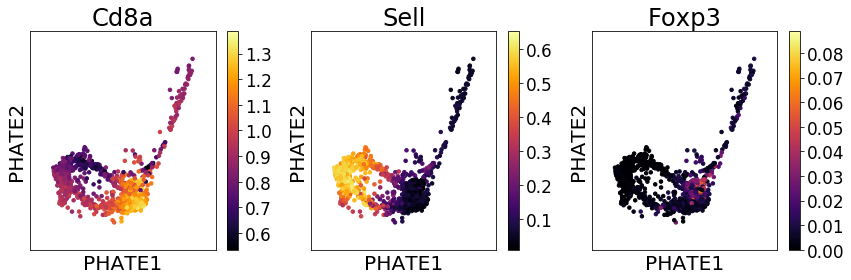

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc, ax=axes[0],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Cd8a"), title="Cd8a",
                     ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[1],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Sell"), title="Sell",
                     ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[2],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Foxp3"), title="Foxp3",
                     ticks=False, label_prefix="PHATE")

plt.tight_layout()

### Visualize distribution of expression across cells for each gene

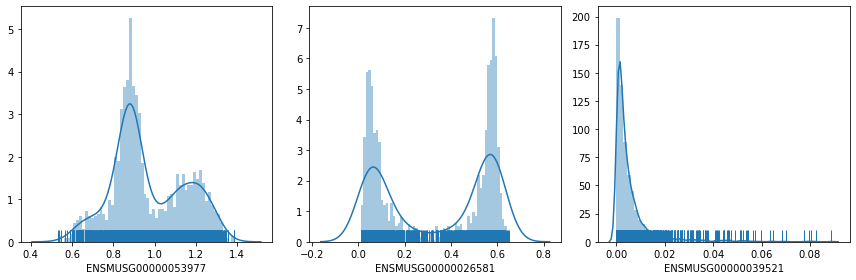

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(dataset.df[ensembl['Cd8a']], rug=True, bins=60, ax=axes[0])

sns.distplot(dataset.df[ensembl['Sell']], rug=True, bins=60, ax=axes[1])

sns.distplot(dataset.df[ensembl['Foxp3']], rug=True, bins=60, ax=axes[2])


plt.tight_layout()

## Train for Cd8a with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [14]:
gene = ensembl['Cd8a']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [15]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Cd8a
Number of first neighbors in graph 443
Number of first neighbors in graph and found in dataset 308


In [16]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

Early stopping metric is mean_squared_error


INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.49, train_metric: 0.50
epoch: 1, time: 0.01, valid_metric: 0.25, train_metric: 0.26
epoch: 2, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 3, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 4, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 5, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 6, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 8, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 9, time: 0.01, valid_metric: 0.10, train_metric: 0.09
epoch: 10, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 11, time: 0.01, valid_metric: 0.09, train_metric: 0.08
epoch: 12, time: 0.01, valid_metric: 0.08, train_metric: 0.08
epoch: 13, time: 0.01, valid_metric: 0.08, train_metric: 0.07
epoch: 14, time: 0.01, valid_metric: 0.07, train_metric: 0.07


INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


epoch: 15, time: 0.01, valid_metric: 0.07, train_metric: 0.07
total train time:1.44 for epochs: 16


INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.77, train_metric: 0.76
epoch: 1, time: 0.01, valid_metric: 0.64, train_metric: 0.63
epoch: 2, time: 0.01, valid_metric: 0.47, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.29, train_metric: 0.28
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.12, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 9, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.76, train_metric: 0.76
epoch: 1, time: 0.01, valid_metric: 0.63, train_metric: 0.63
epoch: 2, time: 0.01, valid_metric: 0.46, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.28, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.12, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 9, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.77, train_metric: 0.76
epoch: 1, time: 0.01, valid_metric: 0.64, train_metric: 0.64
epoch: 2, time: 0.01, valid_metric: 0.48, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.30, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 5, time: 0.01, valid_metric: 0.12, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 9, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.77, train_metric: 0.77
epoch: 1, time: 0.01, valid_metric: 0.64, train_metric: 0.64
epoch: 2, time: 0.01, valid_metric: 0.47, train_metric: 0.48
epoch: 3, time: 0.01, valid_metric: 0.29, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.13, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 9, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 12, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.10, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.79, train_metric: 0.77
epoch: 1, time: 0.01, valid_metric: 0.65, train_metric: 0.64
epoch: 2, time: 0.01, valid_metric: 0.49, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.30, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 9, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.77, train_metric: 0.75
epoch: 1, time: 0.01, valid_metric: 0.64, train_metric: 0.62
epoch: 2, time: 0.01, valid_metric: 0.47, train_metric: 0.46
epoch: 3, time: 0.01, valid_metric: 0.29, train_metric: 0.28
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 9, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.75, train_metric: 0.77
epoch: 1, time: 0.01, valid_metric: 0.62, train_metric: 0.63
epoch: 2, time: 0.01, valid_metric: 0.45, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.28, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.13, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.13, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 9, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 12, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 13, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.10, train_metric: 0.10
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.77, train_metric: 0.76
epoch: 1, time: 0.01, valid_metric: 0.65, train_metric: 0.63
epoch: 2, time: 0.01, valid_metric: 0.48, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.30, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 6, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 9, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 11, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.77, train_metric: 0.76
epoch: 1, time: 0.01, valid_metric: 0.64, train_metric: 0.63
epoch: 2, time: 0.01, valid_metric: 0.48, train_metric: 0.47
epoch: 3, time: 0.01, valid_metric: 0.29, train_metric: 0.29
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 8, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 9, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 10, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 11, time: 0.01, valid_metric: 0.10, train_metric: 0.11
epoch: 12, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 13, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 15, time: 0.01, valid_metric: 0.09, train_metric: 0.09
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.17, train_metric: 0.14
epoch: 1, time: 0.03, valid_metric: 0.14, train_metric: 0.12
epoch: 2, time: 0.02, valid_metric: 0.12, train_metric: 0.10
epoch: 3, time: 0.02, valid_metric: 0.10, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.09, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.08, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.07, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.07, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 11, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.03, valid_metric: 0.04, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.15, train_metric: 0.14
epoch: 1, time: 0.02, valid_metric: 0.13, train_metric: 0.11
epoch: 2, time: 0.03, valid_metric: 0.11, train_metric: 0.09
epoch: 3, time: 0.03, valid_metric: 0.10, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.09, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.08, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.08, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.07, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 11, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.03, valid_metric: 0.04, train_metric: 0.04
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.13, train_metric: 0.15
epoch: 1, time: 0.02, valid_metric: 0.10, train_metric: 0.12
epoch: 2, time: 0.04, valid_metric: 0.08, train_metric: 0.10
epoch: 3, time: 0.03, valid_metric: 0.07, train_metric: 0.09
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.08
epoch: 5, time: 0.03, valid_metric: 0.06, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.02, valid_metric: 0.05, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 11, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.02, valid_metric: 0.04, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.16, train_metric: 0.15
epoch: 1, time: 0.03, valid_metric: 0.13, train_metric: 0.12
epoch: 2, time: 0.03, valid_metric: 0.11, train_metric: 0.10
epoch: 3, time: 0.02, valid_metric: 0.09, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.08, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 11, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.03, valid_metric: 0.03, train_metric: 0.04
epoch: 15, time: 0.02, valid_metric: 0.03, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.14, train_metric: 0.15
epoch: 1, time: 0.04, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.03, valid_metric: 0.09, train_metric: 0.10
epoch: 3, time: 0.03, valid_metric: 0.08, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 5, time: 0.02, valid_metric: 0.06, train_metric: 0.07
epoch: 6, time: 0.02, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.05, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.04, train_metric: 0.05
epoch: 11, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.03, valid_metric: 0.03, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.17, train_metric: 0.14
epoch: 1, time: 0.03, valid_metric: 0.15, train_metric: 0.12
epoch: 2, time: 0.03, valid_metric: 0.13, train_metric: 0.10
epoch: 3, time: 0.03, valid_metric: 0.11, train_metric: 0.09
epoch: 4, time: 0.03, valid_metric: 0.10, train_metric: 0.08
epoch: 5, time: 0.03, valid_metric: 0.08, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.08, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.07, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.07, train_metric: 0.06
epoch: 9, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 11, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 12, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.03, valid_metric: 0.04, train_metric: 0.04
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.15, train_metric: 0.15
epoch: 1, time: 0.03, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.03, valid_metric: 0.09, train_metric: 0.10
epoch: 3, time: 0.03, valid_metric: 0.08, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.04, valid_metric: 0.06, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 11, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.03, valid_metric: 0.03, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.15, train_metric: 0.14
epoch: 1, time: 0.03, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.03, valid_metric: 0.10, train_metric: 0.10
epoch: 3, time: 0.03, valid_metric: 0.08, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 8, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 9, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 11, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 12, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.03, valid_metric: 0.03, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.15, train_metric: 0.15
epoch: 1, time: 0.03, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.03, valid_metric: 0.09, train_metric: 0.09
epoch: 3, time: 0.03, valid_metric: 0.08, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 8, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 9, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 11, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 14, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 15, time: 0.03, valid_metric: 0.03, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.15, train_metric: 0.14
epoch: 1, time: 0.03, valid_metric: 0.12, train_metric: 0.11
epoch: 2, time: 0.03, valid_metric: 0.10, train_metric: 0.09
epoch: 3, time: 0.03, valid_metric: 0.08, train_metric: 0.08
epoch: 4, time: 0.03, valid_metric: 0.07, train_metric: 0.07
epoch: 5, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 6, time: 0.03, valid_metric: 0.06, train_metric: 0.05
epoch: 7, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 8, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 9, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 11, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 12, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 13, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 14, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.03, valid_metric: 0.03, train_metric: 0.03
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.81, train_metric: 0.81
epoch: 1, time: 0.01, valid_metric: 0.72, train_metric: 0.73
epoch: 2, time: 0.01, valid_metric: 0.62, train_metric: 0.63
epoch: 3, time: 0.01, valid_metric: 0.51, train_metric: 0.52
epoch: 4, time: 0.01, valid_metric: 0.39, train_metric: 0.40
epoch: 5, time: 0.01, valid_metric: 0.29, train_metric: 0.30
epoch: 6, time: 0.01, valid_metric: 0.21, train_metric: 0.23
epoch: 7, time: 0.01, valid_metric: 0.16, train_metric: 0.19
epoch: 8, time: 0.01, valid_metric: 0.14, train_metric: 0.17
epoch: 9, time: 0.01, valid_metric: 0.14, train_metric: 0.17
epoch: 10, time: 0.01, valid_metric: 0.13, train_metric: 0.17
epoch: 11, time: 0.01, valid_metric: 0.13, train_metric: 0.16
epoch: 12, time: 0.01, valid_metric: 0.13, train_metric: 0.16
epoch: 13, time: 0.01, valid_metric: 0.13, train_metric: 0.16
epoch: 14, time: 0.01, valid_metric: 0.13, train_metric: 0.16
epoch: 15, time: 0.01, valid_metric: 0.13, train_metric: 0.16
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.83, train_metric: 0.83
epoch: 1, time: 0.01, valid_metric: 0.77, train_metric: 0.77
epoch: 2, time: 0.01, valid_metric: 0.66, train_metric: 0.65
epoch: 3, time: 0.01, valid_metric: 0.52, train_metric: 0.51
epoch: 4, time: 0.01, valid_metric: 0.37, train_metric: 0.37
epoch: 5, time: 0.01, valid_metric: 0.25, train_metric: 0.25
epoch: 6, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 7, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 8, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 9, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 10, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 11, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 12, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 13, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 14, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 15, time: 0.01, valid_metric: 0.14, train_metric: 0.14
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.81, train_metric: 0.81
epoch: 1, time: 0.01, valid_metric: 0.71, train_metric: 0.71
epoch: 2, time: 0.01, valid_metric: 0.57, train_metric: 0.58
epoch: 3, time: 0.01, valid_metric: 0.42, train_metric: 0.42
epoch: 4, time: 0.01, valid_metric: 0.30, train_metric: 0.30
epoch: 5, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 6, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 7, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 8, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 9, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 10, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 11, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 12, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 13, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 14, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 15, time: 0.01, valid_metric: 0.14, train_metric: 0.15
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.78, train_metric: 0.79
epoch: 1, time: 0.01, valid_metric: 0.66, train_metric: 0.67
epoch: 2, time: 0.01, valid_metric: 0.52, train_metric: 0.53
epoch: 3, time: 0.01, valid_metric: 0.37, train_metric: 0.38
epoch: 4, time: 0.01, valid_metric: 0.25, train_metric: 0.26
epoch: 5, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 6, time: 0.01, valid_metric: 0.18, train_metric: 0.17
epoch: 7, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 8, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 9, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 10, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 11, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 12, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 13, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 14, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 15, time: 0.01, valid_metric: 0.16, train_metric: 0.16
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.82, train_metric: 0.83
epoch: 1, time: 0.01, valid_metric: 0.75, train_metric: 0.76
epoch: 2, time: 0.01, valid_metric: 0.66, train_metric: 0.68
epoch: 3, time: 0.01, valid_metric: 0.57, train_metric: 0.58
epoch: 4, time: 0.01, valid_metric: 0.47, train_metric: 0.48
epoch: 5, time: 0.01, valid_metric: 0.37, train_metric: 0.38
epoch: 6, time: 0.01, valid_metric: 0.28, train_metric: 0.29
epoch: 7, time: 0.01, valid_metric: 0.22, train_metric: 0.23
epoch: 8, time: 0.01, valid_metric: 0.18, train_metric: 0.19
epoch: 9, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 10, time: 0.01, valid_metric: 0.16, train_metric: 0.17
epoch: 11, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 12, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 13, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 14, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 15, time: 0.01, valid_metric: 0.15, train_metric: 0.16
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.80, train_metric: 0.81
epoch: 1, time: 0.01, valid_metric: 0.70, train_metric: 0.70
epoch: 2, time: 0.01, valid_metric: 0.59, train_metric: 0.60
epoch: 3, time: 0.01, valid_metric: 0.47, train_metric: 0.48
epoch: 4, time: 0.01, valid_metric: 0.35, train_metric: 0.36
epoch: 5, time: 0.01, valid_metric: 0.25, train_metric: 0.26
epoch: 6, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 7, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 8, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 9, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 10, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 11, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 12, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 13, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 14, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 15, time: 0.01, valid_metric: 0.13, train_metric: 0.14
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.80, train_metric: 0.81
epoch: 1, time: 0.01, valid_metric: 0.69, train_metric: 0.69
epoch: 2, time: 0.01, valid_metric: 0.52, train_metric: 0.53
epoch: 3, time: 0.01, valid_metric: 0.35, train_metric: 0.36
epoch: 4, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 5, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 6, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 7, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 8, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 9, time: 0.01, valid_metric: 0.16, train_metric: 0.17
epoch: 10, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 11, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 12, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 13, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 14, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 15, time: 0.01, valid_metric: 0.16, train_metric: 0.16
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.80, train_metric: 0.81
epoch: 1, time: 0.01, valid_metric: 0.72, train_metric: 0.73
epoch: 2, time: 0.01, valid_metric: 0.58, train_metric: 0.59
epoch: 3, time: 0.01, valid_metric: 0.40, train_metric: 0.40
epoch: 4, time: 0.01, valid_metric: 0.26, train_metric: 0.26
epoch: 5, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 6, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 7, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 8, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 9, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 10, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 11, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 12, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 13, time: 0.01, valid_metric: 0.16, train_metric: 0.15
epoch: 14, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 15, time: 0.01, valid_metric: 0.15, train_metric: 0.15
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.80, train_metric: 0.81
epoch: 1, time: 0.01, valid_metric: 0.72, train_metric: 0.72
epoch: 2, time: 0.01, valid_metric: 0.63, train_metric: 0.63
epoch: 3, time: 0.01, valid_metric: 0.52, train_metric: 0.53
epoch: 4, time: 0.01, valid_metric: 0.43, train_metric: 0.43
epoch: 5, time: 0.01, valid_metric: 0.34, train_metric: 0.34
epoch: 6, time: 0.01, valid_metric: 0.26, train_metric: 0.27
epoch: 7, time: 0.01, valid_metric: 0.20, train_metric: 0.21
epoch: 8, time: 0.01, valid_metric: 0.17, train_metric: 0.18
epoch: 9, time: 0.01, valid_metric: 0.16, train_metric: 0.17
epoch: 10, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 11, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 12, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 13, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 14, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 15, time: 0.01, valid_metric: 0.15, train_metric: 0.15
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.79, train_metric: 0.79
epoch: 1, time: 0.01, valid_metric: 0.69, train_metric: 0.68
epoch: 2, time: 0.01, valid_metric: 0.55, train_metric: 0.54
epoch: 3, time: 0.01, valid_metric: 0.40, train_metric: 0.39
epoch: 4, time: 0.01, valid_metric: 0.27, train_metric: 0.26
epoch: 5, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 6, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 7, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 8, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 9, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 10, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 11, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 12, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 13, time: 0.01, valid_metric: 0.14, train_metric: 0.15
epoch: 14, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 15, time: 0.01, valid_metric: 0.14, train_metric: 0.14
total train time:1

### RMSE results

In [17]:
print('RMSE (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('RMSE (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('RMSE (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

RMSE (first degree): 0.008 +/- 0.001
RMSE (all genes): 0.001 +/- 0.000
RMSE (random genes): 0.022 +/- 0.003


### Accuracy within Error Margin Results

In [18]:
print('Accuracy (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_test[3]), np.std(firstdeg_test[3])))
print('Accuracy (all genes): %.3f +/- %.3f' %(np.mean(fc_test[3]), np.std(fc_test[3])))
print('Accuracy (random genes): %.3f +/- %.3f' %(np.mean(random_test[3]), np.std(random_test[3])))

Accuracy (first degree): 0.710 +/- 0.038
Accuracy (all genes): 0.979 +/- 0.008
Accuracy (random genes): 0.505 +/- 0.033


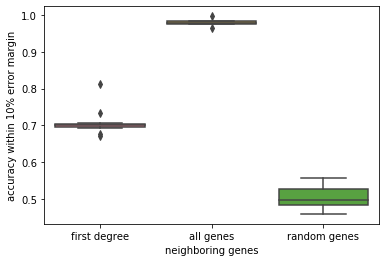

In [19]:
acc_df = pd.DataFrame.from_dict({'first degree': firstdeg_test[3], 
                                 'all genes': fc_test[3],
                                 'random genes': random_test[3]})

acc_df= acc_df.melt()
acc_df.columns = ["neighboring genes", "accuracy within 10% error margin"]
sns.set_palette("husl")
sns.boxplot(x="neighboring genes", y="accuracy within 10% error margin", data=acc_df)

### Visualizing Prediction for Test Data (First Degree Neighbor Genes)

In [20]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [21]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

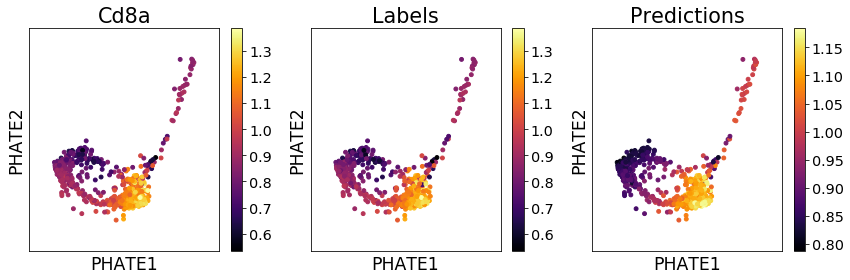

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (All Genes)

In [23]:
fc_test[0]['prediction'] = fc_test[1]
fc_test[0]['label'] = fc_test[2]
fc_test[0].sort_index(inplace=True)

In [24]:
test_mask = data_magic_filt.index.isin(fc_test[0].index)

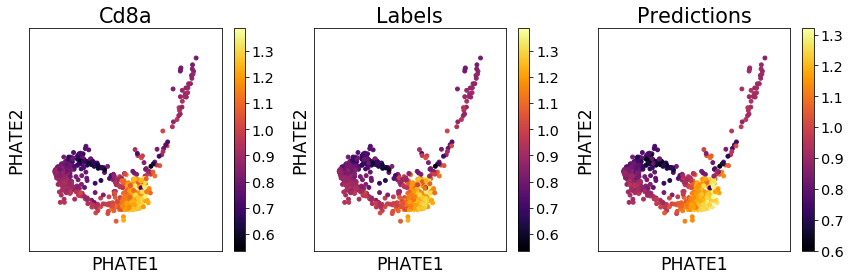

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=fc_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=fc_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (Random Genes)

In [26]:
random_test[0]['prediction'] = random_test[1]
random_test[0]['label'] = random_test[2]
random_test[0].sort_index(inplace=True)

In [27]:
test_mask = data_magic_filt.index.isin(random_test[0].index)

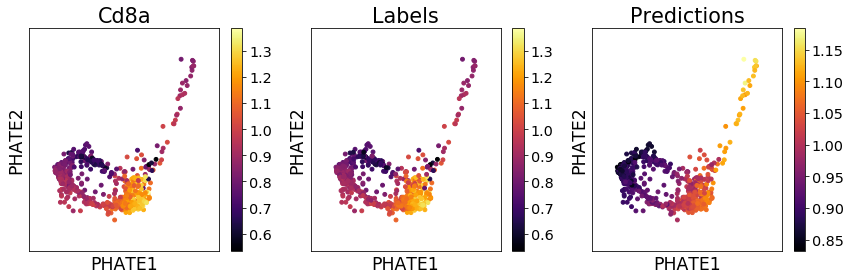

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=random_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=random_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

## Train for Sell with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [29]:
gene = ensembl['Sell']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [30]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Sell
Number of first neighbors in graph 1296
Number of first neighbors in graph and found in dataset 821


In [31]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

Early stopping metric is mean_squared_error


INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 1, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 2, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 3, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 15, time: 0.01, valid_metric: 0.02, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 1, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 3, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 1, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 2, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 3, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 1, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.01, valid_metric: 0.07, train_metric: 0.07
epoch: 3, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.02, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.02, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.02, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 1, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 2, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 3, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.02, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.02, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.02, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.18, train_metric: 0.17
epoch: 1, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 2, time: 0.01, valid_metric: 0.06, train_metric: 0.05
epoch: 3, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.18, train_metric: 0.17
epoch: 1, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 2, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 3, time: 0.01, valid_metric: 0.03, train_metric: 0.04
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 1, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 2, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 3, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 1, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 2, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 3, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.18, train_metric: 0.17
epoch: 1, time: 0.01, valid_metric: 0.11, train_metric: 0.10
epoch: 2, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 3, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 4, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.02, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.02, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.10, train_metric: 0.09
epoch: 1, time: 0.03, valid_metric: 0.05, train_metric: 0.05
epoch: 2, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 3, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 4, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.03, valid_metric: 0.03, train_metric: 0.02
epoch: 7, time: 0.03, valid_metric: 0.03, train_metric: 0.02
epoch: 8, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 9, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.03, valid_metric: 0.02, train_metric: 0.01
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.11, train_metric: 0.10
epoch: 1, time: 0.03, valid_metric: 0.06, train_metric: 0.06
epoch: 2, time: 0.03, valid_metric: 0.05, train_metric: 0.04
epoch: 3, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 5, time: 0.03, valid_metric: 0.04, train_metric: 0.03
epoch: 6, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.03, valid_metric: 0.03, train_metric: 0.02
epoch: 9, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.03, valid_metric: 0.02, train_metric: 0.02
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.10, train_metric: 0.10
epoch: 1, time: 0.02, valid_metric: 0.06, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 3, time: 0.02, valid_metric: 0.03, train_metric: 0.04
epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 8, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.11, train_metric: 0.11
epoch: 1, time: 0.02, valid_metric: 0.05, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 3, time: 0.02, valid_metric: 0.03, train_metric: 0.04
epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.02, valid_metric: 0.02, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.02
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.10, train_metric: 0.10
epoch: 1, time: 0.02, valid_metric: 0.06, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.06, train_metric: 0.05
epoch: 3, time: 0.02, valid_metric: 0.05, train_metric: 0.05
epoch: 4, time: 0.02, valid_metric: 0.05, train_metric: 0.04
epoch: 5, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 6, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 7, time: 0.02, valid_metric: 0.04, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.04, train_metric: 0.03
epoch: 9, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.02, valid_metric: 0.03, train_metric: 0.02
epoch: 12, time: 0.02, valid_metric: 0.03, train_metric: 0.02
epoch: 13, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.02
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.11, train_metric: 0.11
epoch: 1, time: 0.02, valid_metric: 0.06, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.05, train_metric: 0.05
epoch: 3, time: 0.02, valid_metric: 0.05, train_metric: 0.05
epoch: 4, time: 0.02, valid_metric: 0.05, train_metric: 0.04
epoch: 5, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 6, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 7, time: 0.02, valid_metric: 0.04, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 10, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 11, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.02
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.10, train_metric: 0.10
epoch: 1, time: 0.02, valid_metric: 0.06, train_metric: 0.06
epoch: 2, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 3, time: 0.03, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.02, valid_metric: 0.02, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.01
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.10, train_metric: 0.10
epoch: 1, time: 0.02, valid_metric: 0.05, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 3, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 5, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.03, train_metric: 0.02
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.03, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.02, valid_metric: 0.02, train_metric: 0.01
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.01
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.10, train_metric: 0.10
epoch: 1, time: 0.02, valid_metric: 0.05, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 3, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 5, time: 0.03, valid_metric: 0.03, train_metric: 0.03
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.03, train_metric: 0.02
epoch: 9, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 10, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.04, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.02
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.10, train_metric: 0.10
epoch: 1, time: 0.02, valid_metric: 0.06, train_metric: 0.06
epoch: 2, time: 0.02, valid_metric: 0.05, train_metric: 0.05
epoch: 3, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 4, time: 0.02, valid_metric: 0.04, train_metric: 0.04
epoch: 5, time: 0.02, valid_metric: 0.03, train_metric: 0.04
epoch: 6, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 7, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 8, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 9, time: 0.02, valid_metric: 0.03, train_metric: 0.02
epoch: 10, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 11, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 12, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 13, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 14, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 15, time: 0.02, valid_metric: 0.02, train_metric: 0.02
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 1, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 2, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 3, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 4, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 5, time: 0.01, valid_metric: 0.08, train_metric: 0.08
epoch: 6, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 8, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 9, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 11, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 1, time: 0.01, valid_metric: 0.22, train_metric: 0.22
epoch: 2, time: 0.01, valid_metric: 0.20, train_metric: 0.20
epoch: 3, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 4, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 5, time: 0.01, valid_metric: 0.12, train_metric: 0.13
epoch: 6, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 7, time: 0.01, valid_metric: 0.07, train_metric: 0.07
epoch: 8, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 9, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.04
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.22, train_metric: 0.22
epoch: 1, time: 0.01, valid_metric: 0.20, train_metric: 0.20
epoch: 2, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 3, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 4, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 5, time: 0.01, valid_metric: 0.06, train_metric: 0.06
epoch: 6, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.04
epoch: 8, time: 0.01, valid_metric: 0.05, train_metric: 0.04
epoch: 9, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.01, valid_metric: 0.04, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.22, train_metric: 0.23
epoch: 1, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 2, time: 0.01, valid_metric: 0.18, train_metric: 0.19
epoch: 3, time: 0.01, valid_metric: 0.15, train_metric: 0.16
epoch: 4, time: 0.02, valid_metric: 0.12, train_metric: 0.13
epoch: 5, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 6, time: 0.01, valid_metric: 0.07, train_metric: 0.07
epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 8, time: 0.01, valid_metric: 0.05, train_metric: 0.04
epoch: 9, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.04, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.22, train_metric: 0.22
epoch: 1, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 2, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 3, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 4, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 5, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 6, time: 0.01, valid_metric: 0.07, train_metric: 0.08
epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.06
epoch: 8, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 9, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.04
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 1, time: 0.01, valid_metric: 0.22, train_metric: 0.22
epoch: 2, time: 0.01, valid_metric: 0.20, train_metric: 0.20
epoch: 3, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 4, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 5, time: 0.01, valid_metric: 0.12, train_metric: 0.12
epoch: 6, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 7, time: 0.01, valid_metric: 0.07, train_metric: 0.07
epoch: 8, time: 0.01, valid_metric: 0.05, train_metric: 0.06
epoch: 9, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.05
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 14, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 15, time: 0.01, valid_metric: 0.04, train_metric: 0.04
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 1, time: 0.01, valid_metric: 0.22, train_metric: 0.21
epoch: 2, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 3, time: 0.01, valid_metric: 0.15, train_metric: 0.15
epoch: 4, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 5, time: 0.01, valid_metric: 0.08, train_metric: 0.08
epoch: 6, time: 0.01, valid_metric: 0.06, train_metric: 0.05
epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.04
epoch: 8, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 9, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 13, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.04, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.04, train_metric: 0.03
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.24, train_metric: 0.24
epoch: 1, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 2, time: 0.01, valid_metric: 0.22, train_metric: 0.22
epoch: 3, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 4, time: 0.01, valid_metric: 0.20, train_metric: 0.20
epoch: 5, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 6, time: 0.01, valid_metric: 0.18, train_metric: 0.18
epoch: 7, time: 0.01, valid_metric: 0.17, train_metric: 0.16
epoch: 8, time: 0.01, valid_metric: 0.16, train_metric: 0.15
epoch: 9, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 10, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 11, time: 0.01, valid_metric: 0.12, train_metric: 0.11
epoch: 12, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 13, time: 0.01, valid_metric: 0.10, train_metric: 0.10
epoch: 14, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 15, time: 0.01, valid_metric: 0.08, train_metric: 0.08
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.24, train_metric: 0.24
epoch: 1, time: 0.01, valid_metric: 0.23, train_metric: 0.22
epoch: 2, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 3, time: 0.01, valid_metric: 0.19, train_metric: 0.19
epoch: 4, time: 0.01, valid_metric: 0.17, train_metric: 0.17
epoch: 5, time: 0.01, valid_metric: 0.14, train_metric: 0.14
epoch: 6, time: 0.01, valid_metric: 0.11, train_metric: 0.12
epoch: 7, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 8, time: 0.01, valid_metric: 0.06, train_metric: 0.07
epoch: 9, time: 0.01, valid_metric: 0.05, train_metric: 0.06
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.05
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.03, train_metric: 0.04
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.04
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.04
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.04
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.23, train_metric: 0.23
epoch: 1, time: 0.01, valid_metric: 0.21, train_metric: 0.21
epoch: 2, time: 0.01, valid_metric: 0.18, train_metric: 0.19
epoch: 3, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 4, time: 0.01, valid_metric: 0.13, train_metric: 0.13
epoch: 5, time: 0.01, valid_metric: 0.09, train_metric: 0.10
epoch: 6, time: 0.01, valid_metric: 0.06, train_metric: 0.07
epoch: 7, time: 0.01, valid_metric: 0.05, train_metric: 0.05
epoch: 8, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 9, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 10, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 11, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 12, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 13, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 14, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 15, time: 0.01, valid_metric: 0.03, train_metric: 0.03
total train time:1

### RMSE results

In [32]:
print('RMSE (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('RMSE (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('RMSE (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

RMSE (first degree): 0.001 +/- 0.000
RMSE (all genes): 0.000 +/- 0.000
RMSE (random genes): 0.002 +/- 0.001


### Accuracy within Error Margin Results

In [33]:
print('Accuracy (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_test[3]), np.std(firstdeg_test[3])))
print('Accuracy (all genes): %.3f +/- %.3f' %(np.mean(fc_test[3]), np.std(fc_test[3])))
print('Accuracy (random genes): %.3f +/- %.3f' %(np.mean(random_test[3]), np.std(random_test[3])))

Accuracy (first degree): 0.972 +/- 0.005
Accuracy (all genes): 0.997 +/- 0.002
Accuracy (random genes): 0.896 +/- 0.116


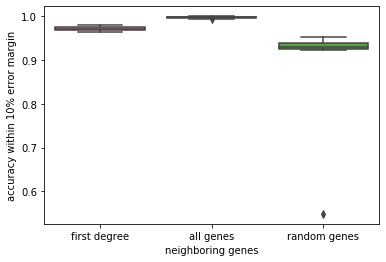

In [34]:
acc_df = pd.DataFrame.from_dict({'first degree': firstdeg_test[3], 
                                 'all genes': fc_test[3],
                                 'random genes': random_test[3]})

acc_df= acc_df.melt()
acc_df.columns = ["neighboring genes", "accuracy within 10% error margin"]
sns.set_palette("husl")
sns.boxplot(x="neighboring genes", y="accuracy within 10% error margin", data=acc_df)

### Visualizing Prediction for Test Data (First Degree Neighbor Genes)

In [35]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [36]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

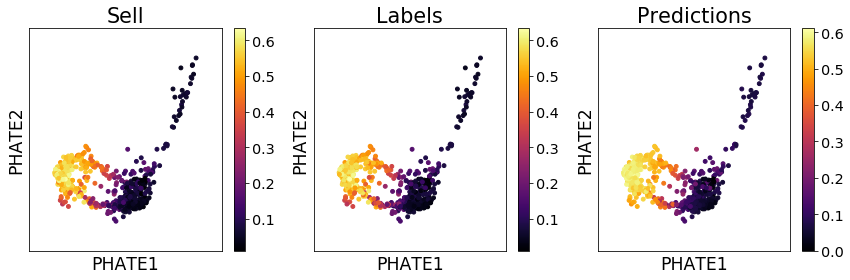

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (All Genes)

In [38]:
fc_test[0]['prediction'] = fc_test[1]
fc_test[0]['label'] = fc_test[2]
fc_test[0].sort_index(inplace=True)

In [39]:
test_mask = data_magic_filt.index.isin(fc_test[0].index)

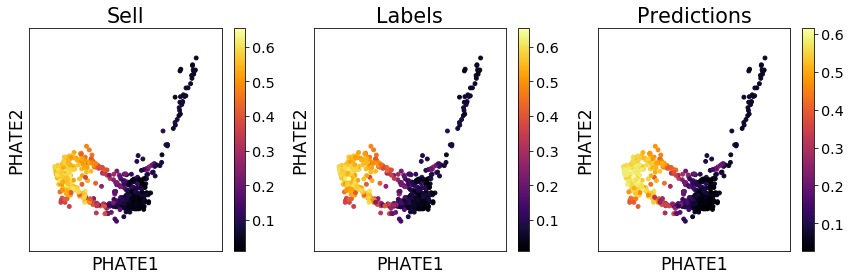

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=fc_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=fc_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (Random Genes)

In [41]:
random_test[0]['prediction'] = random_test[1]
random_test[0]['label'] = random_test[2]
random_test[0].sort_index(inplace=True)

In [42]:
test_mask = data_magic_filt.index.isin(random_test[0].index)

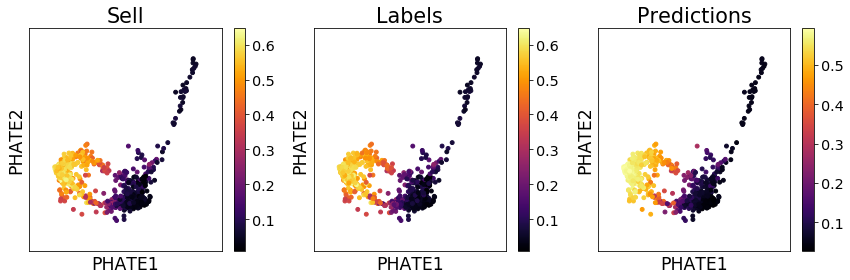

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=random_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=random_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

## Train for Foxp3 with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [44]:
gene = ensembl['Foxp3']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [45]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Foxp3
Number of first neighbors in graph 1636
Number of first neighbors in graph and found in dataset 1076


In [46]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

Early stopping metric is mean_squared_error


INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 5, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 7, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.03, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.03, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.03, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.03, valid_metric: 0.01, train_metric: 0.01
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 10, time: 0.03, valid_metric: 0.00, train_metric: 0.00
epoch: 11, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.00, train_metric: 0.00
total train time:2

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 4, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 5, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 10, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 11, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.03, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.03, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 3, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 4, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 5, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 7, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 9, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 10, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 11, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 6, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 10, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 11, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.01, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.01, train_metric: 0.00
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 2, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 3, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 4, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 5, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 6, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 7, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.00, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 10, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 11, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 12, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 13, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 14, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 15, time: 0.02, valid_metric: 0.00, train_metric: 0.00
epoch: 16, time: 0

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.05, train_metric: 0.06
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 2, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 6, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.16, train_metric: 0.16
epoch: 1, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.03
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.07, train_metric: 0.07
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 2, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.02, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 1, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 2, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 3, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 4, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 1, time: 0.01, valid_metric: 0.04, train_metric: 0.04
epoch: 2, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 6, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 7, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.08, train_metric: 0.08
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.11, train_metric: 0.11
epoch: 1, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.01, train_metric: 0.02
epoch: 6, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.08, train_metric: 0.08
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.02
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 6, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.07, train_metric: 0.07
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 2, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.02, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 6, time: 0.04, valid_metric: 0.01, train_metric: 0.01
epoch: 7, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.02, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

INFO:root:Constructing the network...
INFO:root:Done!


epoch: 0, time: 0.01, valid_metric: 0.09, train_metric: 0.09
epoch: 1, time: 0.01, valid_metric: 0.03, train_metric: 0.03
epoch: 2, time: 0.02, valid_metric: 0.03, train_metric: 0.02
epoch: 3, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 4, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 5, time: 0.01, valid_metric: 0.02, train_metric: 0.02
epoch: 6, time: 0.01, valid_metric: 0.02, train_metric: 0.01
epoch: 7, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 8, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 9, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 10, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 11, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 12, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 13, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 14, time: 0.01, valid_metric: 0.01, train_metric: 0.01
epoch: 15, time: 0.01, valid_metric: 0.01, train_metric: 0.01
total train time:1

### RMSE results

In [47]:
print('RMSE (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('RMSE (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('RMSE (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

RMSE (first degree): 0.000 +/- 0.000
RMSE (all genes): 0.000 +/- 0.000
RMSE (random genes): 0.000 +/- 0.000


### Accuracy within Error Margin Results

In [48]:
print('Accuracy (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_test[3]), np.std(firstdeg_test[3])))
print('Accuracy (all genes): %.3f +/- %.3f' %(np.mean(fc_test[3]), np.std(fc_test[3])))
print('Accuracy (random genes): %.3f +/- %.3f' %(np.mean(random_test[3]), np.std(random_test[3])))

Accuracy (first degree): 0.790 +/- 0.038
Accuracy (all genes): 0.930 +/- 0.092
Accuracy (random genes): 0.854 +/- 0.053


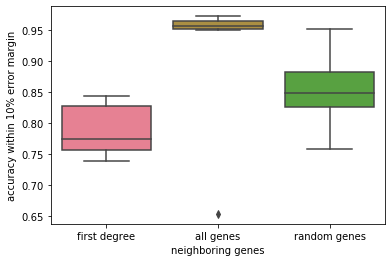

In [49]:
acc_df = pd.DataFrame.from_dict({'first degree': firstdeg_test[3], 
                                 'all genes': fc_test[3],
                                 'random genes': random_test[3]})

acc_df= acc_df.melt()
acc_df.columns = ["neighboring genes", "accuracy within 10% error margin"]
sns.set_palette("husl")
sns.boxplot(x="neighboring genes", y="accuracy within 10% error margin", data=acc_df)

### Visualizing Prediction for Test Data (First Degree Neighbor Genes)

In [50]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [51]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

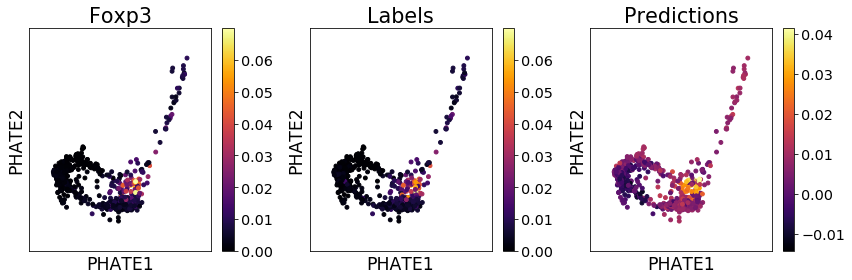

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (All Genes)

In [53]:
fc_test[0]['prediction'] = fc_test[1]
fc_test[0]['label'] = fc_test[2]
fc_test[0].sort_index(inplace=True)

In [54]:
test_mask = data_magic_filt.index.isin(fc_test[0].index)

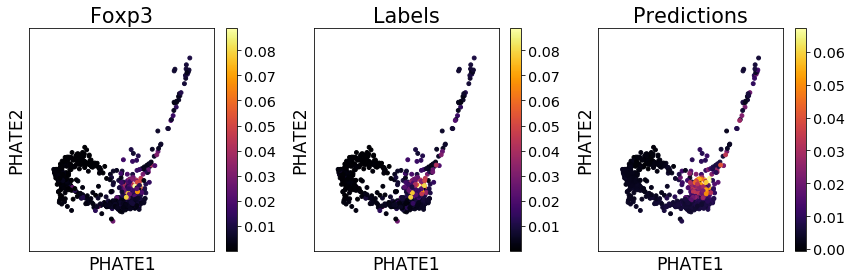

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=fc_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=fc_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

### Visualizing Prediction for Test Data (Random Genes)

In [56]:
random_test[0]['prediction'] = random_test[1]
random_test[0]['label'] = random_test[2]
random_test[0].sort_index(inplace=True)

In [57]:
test_mask = data_magic_filt.index.isin(random_test[0].index)

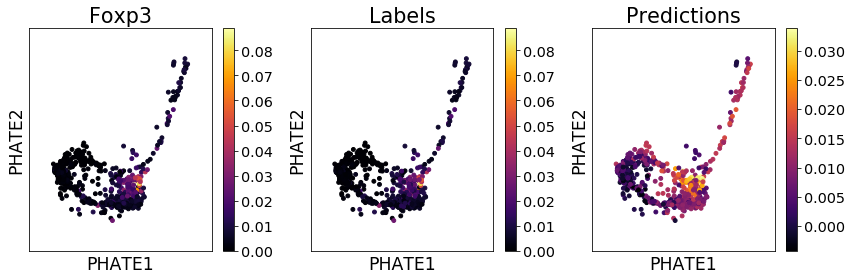

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=random_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=random_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()